In [1]:
import os
import os.path
import sys
import math

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import keras
from keras import layers

Using TensorFlow backend.


In [4]:
sys.path.append(os.path.abspath('../dependencies/BristolStockExchange'))
sys.path.append(os.path.abspath('../src'))

# System setup

Model characteristics:
* Continuous inputs, discrete actions
* Discrete events in continuous time

### Flappy Bird

* State: (hight, lower border of the hole, upper border of the hole, time to hole)
* Actions: {fly up, keep falling}
* Reward: time survived

In [5]:
from reinforcement_example.game import Game

In [ ]:
# Play the game
game = Game()
while True:
    print(game.get_state())
    action = int(input())
    game.time_step(action)
    if not game.alive:
        print("DEAD!")
        break

In [6]:
from reinforcement_example.learner import make_model, make_model_elu

In [7]:
from reinforcement_example.learner import AbstractLearner

In [8]:
from reinforcement_example.learner import ScaledModel, ValueToPolicy

In [9]:
from reinforcement_trading.tools import logodds_to_probs, weights_to_inds, random_round

In [11]:
# class SoftPolicy(object):
#     def __init__(self, base, prob_random):
#         self.base = base
#         self.p = prob_random
        
#     def predict(self, states):
#         res = self.base.predict(states)
#         num_actions = res.shape[1]
#         uniform = np.ones(num_actions) / num_actions
#         res = self.p * uniform + (1 - self.p) * res
#         return res

In [10]:
class TDLearner2(AbstractLearner):
    def __init__(self, state_dim, num_actions, reward_scale=1.0, model_factory=make_model_elu):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.reward_scale = reward_scale
        self.value_model = [ScaledModel(model_factory(state_dim, 1), yscale=reward_scale) for i in range(num_actions)]
        #self.policy = make_model(state_dim, num_actions)
        self.policy = ValueToPolicy(self.value_model, scale=self.reward_scale)
        self.histories = []
        self.history = []
        # Helper arrays for faster training
        self.states = np.empty((0, self.state_dim))
        self.actions = np.empty(0, dtype=np.int)
        self.rewards = np.empty(0)
        self.logprobs = np.empty(0)
        self.ranges = np.empty((0, 2), dtype=np.int)
        self.actinds = [np.empty(0, dtype=np.int) for i in range(self.num_actions)]

    def move(self, state):
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0])
        choice = np.searchsorted(np.cumsum(probs), np.random.rand())
        self.last_action_prob = probs[choice]
        return choice
    
    def _state_value(self, state):
        action_values = np.array([model.predict(state[np.newaxis, :])[0, 0] for model in self.value_model])
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0, :])
        return np.dot(probs, action_values)

    def learn(self, state, action, reward, next_state, value_proxy):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward + self._state_value(next_state)]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))

    def learn_last(self, state, action, reward):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))
        self.histories.append(self.history)
        self.history = []
        self._update_value_model()

    def _update_value_model(self):
        # Update data structures
        dsize = len(self.states)
        for i in range(len(self.ranges), len(self.histories)):
            last_states, last_actions, last_rewards, last_actionprob = zip(*self.histories[i][::-1])
            self.ranges = np.concatenate([self.ranges, np.array([[dsize, dsize + len(last_states)]])])
            dsize += len(last_states)
            self.states = np.concatenate([self.states, np.array(last_states)], axis=0)
            self.actions = np.concatenate([self.actions, np.array(last_actions, dtype=np.int)])
            self.rewards = np.concatenate([self.rewards, last_rewards])
            #self.logprobs = np.concatenate([self.logprobs, [0], np.log(last_actionprob)[:-1]])
            #self.actinds = [np.arange(len(self.actions))[self.actions == i] for i in range(self.num_actions)]
            self.actinds = [np.concatenate([self.actinds[i],
                                            np.arange(dsize - len(last_states), dsize)
                                                [self.actions[dsize - len(last_states):dsize] == i]])
                            for i in range(self.num_actions)]
        # Training
        policy_probs = logodds_to_probs(self.policy.predict(self.states))
        #policy_logprobs = np.log(policy_probs[np.arange(dsize), self.actions])
        #policy_cumlogprobs = np.zeros(dsize)
        #for start, end in self.ranges:
        #    policy_cumlogprobs[start + 1:end] = np.cumsum(policy_logprobs[start:end - 1])
        predicted_state_action_value = np.array([model.predict(self.states)[:, 0] for model in self.value_model]).T
        predicted_state_value = np.sum(policy_probs * predicted_state_action_value, axis=1)
        response = np.empty(self.rewards.shape)
        response[:] = self.rewards
        for start, end in self.ranges:
            response[start + 1:end] += predicted_state_value[start:end - 1]
            # Balance the bias introduced into "future" states when we learn the "past" states
            response[start:end - 1] = 0.5 * (response[start:end - 1] +
                                             predicted_state_value[start + 1:end] - self.rewards[start + 1:end])
        predicted_value = predicted_state_action_value[np.arange(dsize), self.actions]
        # weights = np.exp(policy_logprobs - self.logprobs)
        for action in range(self.num_actions):
            inds = self.actinds[action]  #[weights_to_inds(weights[self.actinds[action]])]
            if len(inds) > 0:
                self.value_model[action].fit(self.states[inds, :], response[inds],
                                             epochs=10#,
                                             #callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=2)]
                                            )
        # Policy scale
        #mse = np.dot(weights, (predicted_value - response) ** 2) / np.sum(weights)
        #self.policy.set_scale(self.reward_scale / len(self.histories) + np.sqrt(mse))
        self.policy.set_scale(self.reward_scale / np.sqrt(len(self.histories)))
        return


In [11]:
from reinforcement_example.learner import train_play

In [12]:
game = Game()
learner = TDLearner2(4, 2, reward_scale=game.mean_time_to_hole)

In [188]:
learner2 = TDLearner(4, 2, reward_scale=game.mean_time_to_hole)
learner2.histories = learner.histories
learner2.value_model = learner.value_model
learner2._update_value_model()
learner_bak = learner
learner = learner2


Epoch 1/10
29552/29552 [==============================] - 2s 71us/step - loss: 41.9196
Epoch 2/10
29552/29552 [==============================] - 2s 80us/step - loss: 41.0478
Epoch 3/10
29552/29552 [==============================] - 2s 77us/step - loss: 41.7494
Epoch 4/10
29552/29552 [==============================] - 2s 71us/step - loss: 42.0738
Epoch 1/10
35995/35995 [==============================] - 3s 78us/step - loss: 22.3180
Epoch 2/10
35995/35995 [==============================] - 3s 72us/step - loss: 22.4159
Epoch 3/10
35995/35995 [==============================] - 3s 74us/step - loss: 22.1707
Epoch 4/10
35995/35995 [==============================] - 3s 73us/step - loss: 22.7951
Epoch 5/10
35995/35995 [==============================] - 3s 76us/step - loss: 22.1064
Epoch 6/10
35995/35995 [==============================] - 3s 78us/step - loss: 22.5506
Epoch 7/10
35995/35995 [==============================] - 3s 72us/step - loss: 22.3347


In [15]:
for i in range(10):
    learner._update_value_model()

Epoch 1/10
17/17 [==============================] - 0s 120us/step - loss: 0.6948
Epoch 2/10
17/17 [==============================] - 0s 127us/step - loss: 0.6943
Epoch 3/10
17/17 [==============================] - 0s 239us/step - loss: 0.6937
Epoch 4/10
17/17 [==============================] - 0s 130us/step - loss: 0.6933
Epoch 5/10
17/17 [==============================] - 0s 140us/step - loss: 0.6928
Epoch 6/10
17/17 [==============================] - 0s 141us/step - loss: 0.6924
Epoch 7/10
17/17 [==============================] - 0s 173us/step - loss: 0.6920
Epoch 8/10
17/17 [==============================] - 0s 164us/step - loss: 0.6917
Epoch 9/10
17/17 [==============================] - 0s 137us/step - loss: 0.6913
Epoch 10/10
17/17 [==============================] - 0s 147us/step - loss: 0.6910
Epoch 1/10
9/9 [==============================] - 0s 282us/step - loss: 2.7371
Epoch 2/10
9/9 [==============================] - 0s 228us/step - loss: 2.4339
Epoch 3/10
9/9 [===============

Epoch 4/10
17/17 [==============================] - 0s 128us/step - loss: 0.2714
Epoch 5/10
17/17 [==============================] - 0s 124us/step - loss: 0.2714
Epoch 6/10
17/17 [==============================] - 0s 211us/step - loss: 0.2714
Epoch 7/10
17/17 [==============================] - 0s 152us/step - loss: 0.2714
Epoch 8/10
17/17 [==============================] - 0s 276us/step - loss: 0.2714
Epoch 9/10
17/17 [==============================] - 0s 218us/step - loss: 0.2714
Epoch 10/10
17/17 [==============================] - 0s 196us/step - loss: 0.2714
Epoch 1/10
9/9 [==============================] - 0s 568us/step - loss: 1.1078
Epoch 2/10
9/9 [==============================] - 0s 458us/step - loss: 1.1075
Epoch 3/10
9/9 [==============================] - 0s 279us/step - loss: 0.9776
Epoch 4/10
9/9 [==============================] - 0s 234us/step - loss: 0.9617
Epoch 5/10
9/9 [==============================] - 0s 209us/step - loss: 0.9005
Epoch 6/10
9/9 [=====================

In [13]:
def show_history(history):
    x = np.zeros(len(history))
    x[1:] = np.cumsum([info[2] for info in history[:-1]])
    y = np.array([info[0][0] for info in history])
    gates = dict()
    for i in range(len(history)):
        gx = x[i] + history[i][0][3]
        gl = history[i][0][1]
        gu = history[i][0][2]
        gates[np.round(gx)] = (gx, gl, gu)
    plt.plot(x, y, '-*')
    for gx, gl, gu in gates.values():
        plt.plot([gx, gx], [0, gl], 'r-')
        plt.plot([gx, gx], [gu, 100], 'r-')

Epoch 1/10
17/17 [==============================] - 0s 26ms/step - loss: 2.3049
Epoch 2/10
17/17 [==============================] - 0s 304us/step - loss: 1.4341
Epoch 3/10
17/17 [==============================] - 0s 136us/step - loss: 1.4164
Epoch 4/10
17/17 [==============================] - 0s 468us/step - loss: 1.4065
Epoch 5/10
17/17 [==============================] - 0s 161us/step - loss: 1.3999
Epoch 6/10
17/17 [==============================] - 0s 398us/step - loss: 1.3953
Epoch 7/10
17/17 [==============================] - 0s 143us/step - loss: 1.3917
Epoch 8/10
17/17 [==============================] - 0s 153us/step - loss: 1.3890
Epoch 9/10
17/17 [==============================] - 0s 150us/step - loss: 1.3867
Epoch 10/10
17/17 [==============================] - 0s 172us/step - loss: 1.3848
Epoch 1/10
9/9 [==============================] - 0s 13ms/step - loss: 4.6625
Epoch 2/10
9/9 [==============================] - 0s 226us/step - loss: 4.1355
Epoch 3/10
9/9 [=================

29.794286898124284

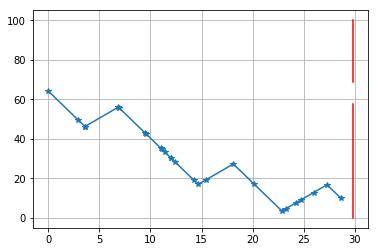

In [14]:
fooh, foor = train_play(Game(), learner)
show_history(fooh)
plt.grid(True)
foor

In [163]:
fooh[-1]

(array([53.92746374, 87.94064598, 88.2871137 ,  0.13904493]),
 1,
 0.13904492872458163)

In [20]:
history = []

Epoch 1/10
25844/25844 [==============================] - 2s 69us/step - loss: 0.4973
Epoch 2/10
25844/25844 [==============================] - 2s 68us/step - loss: 0.4962
Epoch 3/10
25844/25844 [==============================] - 2s 68us/step - loss: 0.4929
Epoch 4/10
25844/25844 [==============================] - 2s 66us/step - loss: 0.4948
Epoch 5/10
25844/25844 [==============================] - 2s 70us/step - loss: 0.4923
Epoch 6/10
25844/25844 [==============================] - 2s 68us/step - loss: 0.4937
Epoch 7/10
25844/25844 [==============================] - 2s 67us/step - loss: 0.4916
Epoch 8/10
25844/25844 [==============================] - 2s 67us/step - loss: 0.4923
Epoch 9/10
25844/25844 [==============================] - 2s 68us/step - loss: 0.4879
Epoch 10/10
25844/25844 [==============================] - 2s 71us/step - loss: 0.4905
Epoch 1/10
29470/29470 [==============================] - 2s 72us/step - loss: 0.3979
Epoch 2/10
29470/29470 [=============================

Epoch 1/10
29784/29784 [==============================] - 2s 62us/step - loss: 0.4513
Epoch 2/10
29784/29784 [==============================] - 2s 63us/step - loss: 0.4495
Epoch 3/10
29784/29784 [==============================] - 2s 61us/step - loss: 0.4510
Epoch 4/10
29784/29784 [==============================] - 2s 63us/step - loss: 0.4481
Epoch 5/10
29784/29784 [==============================] - 2s 65us/step - loss: 0.4466
Epoch 6/10
29784/29784 [==============================] - 2s 63us/step - loss: 0.4468
Epoch 7/10
29784/29784 [==============================] - 2s 72us/step - loss: 0.4443
Epoch 8/10
29784/29784 [==============================] - 2s 67us/step - loss: 0.4462
Epoch 9/10
29784/29784 [==============================] - 2s 63us/step - loss: 0.4480
Epoch 10/10
29784/29784 [==============================] - 2s 65us/step - loss: 0.4459
Epoch 1/10
26062/26062 [==============================] - 2s 65us/step - loss: 0.5258
Epoch 2/10
26062/26062 [=============================

26294/26294 [==============================] - 2s 67us/step - loss: 0.6140
Epoch 2/10
26294/26294 [==============================] - 2s 62us/step - loss: 0.6042
Epoch 3/10
26294/26294 [==============================] - 2s 67us/step - loss: 0.6054
Epoch 4/10
26294/26294 [==============================] - 2s 66us/step - loss: 0.6036
Epoch 5/10
26294/26294 [==============================] - 2s 64us/step - loss: 0.6035
Epoch 6/10
26294/26294 [==============================] - 2s 64us/step - loss: 0.6007
Epoch 7/10
26294/26294 [==============================] - 2s 62us/step - loss: 0.6000
Epoch 8/10
26294/26294 [==============================] - 2s 64us/step - loss: 0.6009
Epoch 9/10
26294/26294 [==============================] - 2s 63us/step - loss: 0.6048
Epoch 10/10
26294/26294 [==============================] - 2s 68us/step - loss: 0.6007
Epoch 1/10
30151/30151 [==============================] - 2s 66us/step - loss: 0.5864
Epoch 2/10
30151/30151 [==============================] - 2s 69u

30478/30478 [==============================] - 2s 63us/step - loss: 0.5072
Epoch 2/10
30478/30478 [==============================] - 2s 63us/step - loss: 0.5068
Epoch 3/10
30478/30478 [==============================] - 2s 63us/step - loss: 0.5024
Epoch 4/10
30478/30478 [==============================] - 2s 63us/step - loss: 0.5032
Epoch 5/10
30478/30478 [==============================] - 2s 63us/step - loss: 0.5049
Epoch 6/10
30478/30478 [==============================] - 2s 63us/step - loss: 0.5013
Epoch 7/10
30478/30478 [==============================] - 2s 66us/step - loss: 0.5020
Epoch 8/10
30478/30478 [==============================] - 2s 69us/step - loss: 0.4996
Epoch 9/10
30478/30478 [==============================] - 2s 69us/step - loss: 0.4988
Epoch 10/10
30478/30478 [==============================] - 2s 66us/step - loss: 0.5030
Epoch 1/10
26571/26571 [==============================] - 2s 65us/step - loss: 0.5860
Epoch 2/10
26571/26571 [==============================] - 2s 66u

26970/26970 [==============================] - 2s 64us/step - loss: 0.4687
Epoch 2/10
26970/26970 [==============================] - 2s 64us/step - loss: 0.4671
Epoch 3/10
26970/26970 [==============================] - 2s 63us/step - loss: 0.4617
Epoch 4/10
26970/26970 [==============================] - 2s 64us/step - loss: 0.4635
Epoch 5/10
26970/26970 [==============================] - 2s 65us/step - loss: 0.4652
Epoch 6/10
26970/26970 [==============================] - 2s 62us/step - loss: 0.4646
Epoch 7/10
26970/26970 [==============================] - 2s 62us/step - loss: 0.4672
Epoch 8/10
26970/26970 [==============================] - 2s 63us/step - loss: 0.4681
Epoch 9/10
26970/26970 [==============================] - 2s 64us/step - loss: 0.4650
Epoch 10/10
26970/26970 [==============================] - 2s 64us/step - loss: 0.4659
Epoch 1/10
30936/30936 [==============================] - 2s 64us/step - loss: 0.4730
Epoch 2/10
30936/30936 [==============================] - 2s 62u

31348/31348 [==============================] - 2s 61us/step - loss: 0.4943
Epoch 2/10
31348/31348 [==============================] - 2s 62us/step - loss: 0.4895
Epoch 3/10
31348/31348 [==============================] - 2s 62us/step - loss: 0.4901
Epoch 4/10
31348/31348 [==============================] - 2s 65us/step - loss: 0.4858
Epoch 5/10
31348/31348 [==============================] - 2s 64us/step - loss: 0.4867
Epoch 6/10
31348/31348 [==============================] - 2s 65us/step - loss: 0.4861
Epoch 7/10
31348/31348 [==============================] - 2s 65us/step - loss: 0.4857
Epoch 8/10
31348/31348 [==============================] - 2s 63us/step - loss: 0.4826
Epoch 9/10
31348/31348 [==============================] - 2s 64us/step - loss: 0.4808
Epoch 10/10
31348/31348 [==============================] - 2s 64us/step - loss: 0.4839
Epoch 1/10
27197/27197 [==============================] - 2s 63us/step - loss: 0.5344
Epoch 2/10
27197/27197 [==============================] - 2s 62u

27371/27371 [==============================] - 2s 65us/step - loss: 0.7293
Epoch 2/10
27371/27371 [==============================] - 2s 63us/step - loss: 0.7305
Epoch 3/10
27371/27371 [==============================] - 2s 63us/step - loss: 0.7227
Epoch 4/10
27371/27371 [==============================] - 2s 63us/step - loss: 0.7318
Epoch 5/10
27371/27371 [==============================] - 2s 66us/step - loss: 0.7240
Epoch 6/10
27371/27371 [==============================] - 2s 63us/step - loss: 0.7204
Epoch 7/10
27371/27371 [==============================] - 2s 64us/step - loss: 0.7366
Epoch 8/10
27371/27371 [==============================] - 2s 66us/step - loss: 0.7261
Epoch 9/10
27371/27371 [==============================] - 2s 62us/step - loss: 0.7292
Epoch 10/10
27371/27371 [==============================] - 2s 64us/step - loss: 0.7284
Epoch 1/10
31846/31846 [==============================] - 2s 64us/step - loss: 0.6822
Epoch 2/10
31846/31846 [==============================] - 2s 64u

32238/32238 [==============================] - 2s 66us/step - loss: 0.8096
Epoch 2/10
32238/32238 [==============================] - 2s 62us/step - loss: 0.8032
Epoch 3/10
32238/32238 [==============================] - 2s 62us/step - loss: 0.8011
Epoch 4/10
32238/32238 [==============================] - 2s 63us/step - loss: 0.8026
Epoch 5/10
32238/32238 [==============================] - 2s 66us/step - loss: 0.7998
Epoch 6/10
32238/32238 [==============================] - 2s 63us/step - loss: 0.7991
Epoch 7/10
32238/32238 [==============================] - 2s 65us/step - loss: 0.8015
Epoch 8/10
32238/32238 [==============================] - 2s 67us/step - loss: 0.8001
Epoch 9/10
32238/32238 [==============================] - 2s 66us/step - loss: 0.8022
Epoch 10/10
32238/32238 [==============================] - 2s 66us/step - loss: 0.8014
Epoch 1/10
27637/27637 [==============================] - 2s 65us/step - loss: 1.0272
Epoch 2/10
27637/27637 [==============================] - 2s 63u

28013/28013 [==============================] - 2s 62us/step - loss: 0.9200
Epoch 2/10
28013/28013 [==============================] - 2s 62us/step - loss: 0.9136
Epoch 3/10
28013/28013 [==============================] - 2s 64us/step - loss: 0.9160
Epoch 4/10
28013/28013 [==============================] - 2s 63us/step - loss: 0.9186
Epoch 5/10
28013/28013 [==============================] - 2s 65us/step - loss: 0.9177
Epoch 6/10
28013/28013 [==============================] - 2s 64us/step - loss: 0.9064
Epoch 7/10
28013/28013 [==============================] - 2s 64us/step - loss: 0.9160
Epoch 8/10
28013/28013 [==============================] - 2s 67us/step - loss: 0.9149
Epoch 9/10
28013/28013 [==============================] - 2s 65us/step - loss: 0.9132
Epoch 10/10
28013/28013 [==============================] - 2s 64us/step - loss: 0.9205
Epoch 1/10
32803/32803 [==============================] - 2s 65us/step - loss: 0.8552
Epoch 2/10
32803/32803 [==============================] - 2s 65u

33267/33267 [==============================] - 2s 62us/step - loss: 0.8933
Epoch 2/10
33267/33267 [==============================] - 2s 65us/step - loss: 0.8826
Epoch 3/10
33267/33267 [==============================] - 2s 67us/step - loss: 0.8866
Epoch 4/10
33267/33267 [==============================] - 2s 66us/step - loss: 0.8879
Epoch 5/10
33267/33267 [==============================] - 2s 64us/step - loss: 0.8859
Epoch 6/10
33267/33267 [==============================] - 2s 64us/step - loss: 0.8903
Epoch 7/10
33267/33267 [==============================] - 2s 63us/step - loss: 0.8863
Epoch 8/10
33267/33267 [==============================] - 2s 63us/step - loss: 0.8927
Epoch 9/10
33267/33267 [==============================] - 2s 61us/step - loss: 0.8806
Epoch 10/10
33267/33267 [==============================] - 2s 62us/step - loss: 0.8829
Epoch 1/10
28298/28298 [==============================] - 2s 63us/step - loss: 1.2845
Epoch 2/10
28298/28298 [==============================] - 2s 64u

28528/28528 [==============================] - 2s 64us/step - loss: 1.4248
Epoch 2/10
28528/28528 [==============================] - 2s 65us/step - loss: 1.4221
Epoch 3/10
28528/28528 [==============================] - 2s 63us/step - loss: 1.4130
Epoch 4/10
28528/28528 [==============================] - 2s 64us/step - loss: 1.4139
Epoch 5/10
28528/28528 [==============================] - 2s 65us/step - loss: 1.4191
Epoch 6/10
28528/28528 [==============================] - 2s 64us/step - loss: 1.4155
Epoch 7/10
28528/28528 [==============================] - 2s 63us/step - loss: 1.4096
Epoch 8/10
28528/28528 [==============================] - 2s 66us/step - loss: 1.4016
Epoch 9/10
28528/28528 [==============================] - 2s 64us/step - loss: 1.4059
Epoch 10/10
28528/28528 [==============================] - 2s 62us/step - loss: 1.4023
Epoch 1/10
33783/33783 [==============================] - 2s 63us/step - loss: 1.0963
Epoch 2/10
33783/33783 [==============================] - 2s 63u

34122/34122 [==============================] - 2s 65us/step - loss: 1.0845
Epoch 7/10
34122/34122 [==============================] - 2s 64us/step - loss: 1.0900
Epoch 8/10
34122/34122 [==============================] - 2s 64us/step - loss: 1.0841
Epoch 9/10
34122/34122 [==============================] - 2s 65us/step - loss: 1.0820
Epoch 10/10
34122/34122 [==============================] - 2s 65us/step - loss: 1.0850
Epoch 1/10
28722/28722 [==============================] - 2s 65us/step - loss: 1.3357
Epoch 2/10
28722/28722 [==============================] - 2s 65us/step - loss: 1.3347
Epoch 3/10
28722/28722 [==============================] - 2s 62us/step - loss: 1.3415
Epoch 4/10
28722/28722 [==============================] - 2s 64us/step - loss: 1.3365
Epoch 5/10
28722/28722 [==============================] - 2s 66us/step - loss: 1.3300
Epoch 6/10
28722/28722 [==============================] - 2s 63us/step - loss: 1.3316
Epoch 7/10
28722/28722 [==============================] - 2s 64u

28919/28919 [==============================] - 2s 76us/step - loss: 1.8627
Epoch 7/10
28919/28919 [==============================] - 2s 71us/step - loss: 1.8433
Epoch 8/10
28919/28919 [==============================] - 2s 77us/step - loss: 1.8425
Epoch 9/10
28919/28919 [==============================] - 2s 71us/step - loss: 1.8406
Epoch 10/10
28919/28919 [==============================] - 2s 75us/step - loss: 1.8394
Epoch 1/10
34589/34589 [==============================] - 3s 81us/step - loss: 1.1542
Epoch 2/10
34589/34589 [==============================] - 3s 77us/step - loss: 1.1465
Epoch 3/10
34589/34589 [==============================] - 2s 68us/step - loss: 1.1469
Epoch 4/10
34589/34589 [==============================] - 2s 70us/step - loss: 1.1438
Epoch 5/10
34589/34589 [==============================] - 3s 74us/step - loss: 1.1434
Epoch 6/10
34589/34589 [==============================] - 2s 68us/step - loss: 1.1518
Epoch 7/10
34589/34589 [==============================] - 3s 79u

35062/35062 [==============================] - 2s 71us/step - loss: 2.0418
Epoch 7/10
35062/35062 [==============================] - 2s 67us/step - loss: 2.0223
Epoch 8/10
35062/35062 [==============================] - 2s 65us/step - loss: 2.0333
Epoch 9/10
35062/35062 [==============================] - 2s 68us/step - loss: 2.0166
Epoch 10/10
35062/35062 [==============================] - 2s 69us/step - loss: 1.9848
Epoch 1/10
29081/29081 [==============================] - 2s 65us/step - loss: 2.5281
Epoch 2/10
29081/29081 [==============================] - 2s 63us/step - loss: 2.4482
Epoch 3/10
29081/29081 [==============================] - 2s 66us/step - loss: 2.3979
Epoch 4/10
29081/29081 [==============================] - 2s 62us/step - loss: 2.4189
Epoch 5/10
29081/29081 [==============================] - 2s 64us/step - loss: 2.4066
Epoch 6/10
29081/29081 [==============================] - 2s 63us/step - loss: 2.4542
Epoch 7/10
29081/29081 [==============================] - 2s 64u

29339/29339 [==============================] - 2s 66us/step - loss: 3.6679
Epoch 7/10
29339/29339 [==============================] - 2s 64us/step - loss: 3.7288
Epoch 8/10
29339/29339 [==============================] - 2s 62us/step - loss: 3.8834
Epoch 9/10
29339/29339 [==============================] - 2s 64us/step - loss: 3.7566
Epoch 10/10
29339/29339 [==============================] - 2s 62us/step - loss: 3.7959
Epoch 1/10
35656/35656 [==============================] - 2s 64us/step - loss: 1.8479
Epoch 2/10
35656/35656 [==============================] - 2s 66us/step - loss: 1.8402
Epoch 3/10
35656/35656 [==============================] - 2s 66us/step - loss: 1.8243
Epoch 4/10
35656/35656 [==============================] - 2s 64us/step - loss: 1.8404
Epoch 5/10
35656/35656 [==============================] - 2s 68us/step - loss: 1.8318
Epoch 6/10
35656/35656 [==============================] - 2s 66us/step - loss: 1.8167
Epoch 7/10
35656/35656 [==============================] - 2s 64u

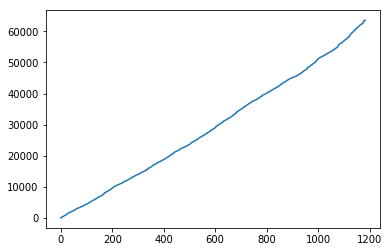

In [170]:
for i in range(10000):
    history.append(train_play(Game(), learner)[1])
    if len(history) % 100 == 0:
        print(len(history))
    if os.path.exists("002_reinforcement_example_v5_stop"):
        break
plt.plot(np.cumsum(history))

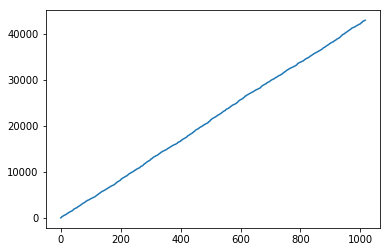

In [53]:
plt.plot(np.cumsum(history))

Epoch 1/10
29/29 [==============================] - 0s 62us/step - loss: 0.5156
Epoch 2/10
29/29 [==============================] - 0s 92us/step - loss: 0.4853
Epoch 3/10
29/29 [==============================] - 0s 86us/step - loss: 0.4772
Epoch 4/10
29/29 [==============================] - 0s 64us/step - loss: 0.4725
Epoch 5/10
29/29 [==============================] - 0s 64us/step - loss: 0.4691
Epoch 6/10
29/29 [==============================] - 0s 122us/step - loss: 0.4665
Epoch 7/10
29/29 [==============================] - 0s 118us/step - loss: 0.4644
Epoch 8/10
29/29 [==============================] - 0s 98us/step - loss: 0.4626
Epoch 9/10
29/29 [==============================] - 0s 105us/step - loss: 0.4611
Epoch 10/10
29/29 [==============================] - 0s 97us/step - loss: 0.4597
Epoch 1/10
25/25 [==============================] - 0s 107us/step - loss: 0.5817
Epoch 2/10
25/25 [==============================] - 0s 114us/step - loss: 0.4404
Epoch 3/10
25/25 [================

185/185 [==============================] - 0s 78us/step - loss: 0.1773
Epoch 2/10
185/185 [==============================] - 0s 96us/step - loss: 0.1734
Epoch 3/10
185/185 [==============================] - 0s 155us/step - loss: 0.1704
Epoch 4/10
185/185 [==============================] - 0s 66us/step - loss: 0.1679
Epoch 5/10
185/185 [==============================] - 0s 93us/step - loss: 0.1659
Epoch 6/10
185/185 [==============================] - 0s 96us/step - loss: 0.1641
Epoch 7/10
185/185 [==============================] - 0s 74us/step - loss: 0.1626
Epoch 8/10
185/185 [==============================] - 0s 99us/step - loss: 0.1611
Epoch 9/10
185/185 [==============================] - 0s 108us/step - loss: 0.1600
Epoch 10/10
185/185 [==============================] - 0s 96us/step - loss: 0.1591
Epoch 1/10
147/147 [==============================] - 0s 112us/step - loss: 0.2386
Epoch 2/10
147/147 [==============================] - 0s 109us/step - loss: 0.2224
Epoch 3/10
147/147 [==

213/213 [==============================] - 0s 82us/step - loss: 0.1964
Epoch 1/10
312/312 [==============================] - 0s 92us/step - loss: 0.1625
Epoch 2/10
312/312 [==============================] - 0s 103us/step - loss: 0.1607
Epoch 3/10
312/312 [==============================] - 0s 88us/step - loss: 0.1583
Epoch 4/10
312/312 [==============================] - 0s 78us/step - loss: 0.1555
Epoch 5/10
312/312 [==============================] - 0s 75us/step - loss: 0.1522
Epoch 6/10
312/312 [==============================] - 0s 91us/step - loss: 0.1489
Epoch 7/10
312/312 [==============================] - 0s 98us/step - loss: 0.1463
Epoch 8/10
312/312 [==============================] - 0s 75us/step - loss: 0.1445
Epoch 9/10
312/312 [==============================] - 0s 101us/step - loss: 0.1427
Epoch 10/10
312/312 [==============================] - 0s 99us/step - loss: 0.1437
Epoch 1/10
228/228 [==============================] - 0s 139us/step - loss: 0.1743
Epoch 2/10
228/228 [===

305/305 [==============================] - 0s 64us/step - loss: 0.1606
Epoch 10/10
305/305 [==============================] - 0s 71us/step - loss: 0.2024
Epoch 1/10
382/382 [==============================] - 0s 79us/step - loss: 0.4398
Epoch 2/10
382/382 [==============================] - 0s 94us/step - loss: 0.4303
Epoch 3/10
382/382 [==============================] - 0s 74us/step - loss: 0.4210
Epoch 4/10
382/382 [==============================] - 0s 66us/step - loss: 0.4128
Epoch 5/10
382/382 [==============================] - 0s 70us/step - loss: 0.4119
Epoch 6/10
382/382 [==============================] - 0s 69us/step - loss: 0.3963
Epoch 7/10
382/382 [==============================] - 0s 56us/step - loss: 0.3953
Epoch 8/10
382/382 [==============================] - 0s 75us/step - loss: 0.3858
Epoch 9/10
382/382 [==============================] - 0s 66us/step - loss: 0.3803
Epoch 10/10
382/382 [==============================] - 0s 108us/step - loss: 0.3753
Epoch 1/10
317/317 [====

372/372 [==============================] - 0s 97us/step - loss: 0.1883
Epoch 9/10
372/372 [==============================] - 0s 90us/step - loss: 0.1676
Epoch 10/10
372/372 [==============================] - 0s 80us/step - loss: 0.1081
Epoch 1/10
484/484 [==============================] - 0s 69us/step - loss: 0.1949
Epoch 2/10
484/484 [==============================] - 0s 96us/step - loss: 0.2129
Epoch 3/10
484/484 [==============================] - 0s 92us/step - loss: 0.1768
Epoch 4/10
484/484 [==============================] - 0s 72us/step - loss: 0.2130
Epoch 5/10
484/484 [==============================] - 0s 81us/step - loss: 0.2029
Epoch 6/10
484/484 [==============================] - 0s 70us/step - loss: 0.2286
Epoch 7/10
484/484 [==============================] - 0s 65us/step - loss: 0.2120
Epoch 8/10
484/484 [==============================] - 0s 75us/step - loss: 0.2321
Epoch 9/10
484/484 [==============================] - 0s 66us/step - loss: 0.1961
Epoch 10/10
484/484 [=====

495/495 [==============================] - 0s 67us/step - loss: 0.1450
Epoch 8/10
495/495 [==============================] - 0s 73us/step - loss: 0.1082
Epoch 9/10
495/495 [==============================] - 0s 63us/step - loss: 0.1703
Epoch 10/10
495/495 [==============================] - 0s 64us/step - loss: 0.1302
Epoch 1/10
536/536 [==============================] - 0s 73us/step - loss: 0.3964
Epoch 2/10
536/536 [==============================] - 0s 100us/step - loss: 0.3885
Epoch 3/10
536/536 [==============================] - 0s 87us/step - loss: 0.4045
Epoch 4/10
536/536 [==============================] - 0s 65us/step - loss: 0.3611
Epoch 5/10
536/536 [==============================] - 0s 68us/step - loss: 0.3647
Epoch 6/10
536/536 [==============================] - 0s 67us/step - loss: 0.3582
Epoch 7/10
536/536 [==============================] - 0s 68us/step - loss: 0.3524
Epoch 8/10
536/536 [==============================] - 0s 72us/step - loss: 0.3416
Epoch 9/10
536/536 [=====

595/595 [==============================] - 0s 67us/step - loss: 0.1169
Epoch 7/10
595/595 [==============================] - 0s 62us/step - loss: 0.1473
Epoch 8/10
595/595 [==============================] - 0s 76us/step - loss: 0.1289
Epoch 9/10
595/595 [==============================] - 0s 69us/step - loss: 0.1338
Epoch 10/10
595/595 [==============================] - 0s 63us/step - loss: 0.1332
Epoch 1/10
631/631 [==============================] - 0s 66us/step - loss: 0.3960
Epoch 2/10
631/631 [==============================] - 0s 59us/step - loss: 0.3755
Epoch 3/10
631/631 [==============================] - 0s 62us/step - loss: 0.3860
Epoch 4/10
631/631 [==============================] - 0s 72us/step - loss: 0.3784
Epoch 5/10
631/631 [==============================] - 0s 63us/step - loss: 0.3488
Epoch 6/10
631/631 [==============================] - 0s 64us/step - loss: 0.4416
Epoch 7/10
631/631 [==============================] - 0s 64us/step - loss: 0.3795
Epoch 8/10
631/631 [======

735/735 [==============================] - 0s 60us/step - loss: 0.1403
Epoch 6/10
735/735 [==============================] - 0s 61us/step - loss: 0.1466
Epoch 7/10
735/735 [==============================] - 0s 60us/step - loss: 0.1326
Epoch 8/10
735/735 [==============================] - 0s 58us/step - loss: 0.1490
Epoch 9/10
735/735 [==============================] - 0s 64us/step - loss: 0.1129
Epoch 10/10
735/735 [==============================] - 0s 67us/step - loss: 0.1330
Epoch 1/10
679/679 [==============================] - 0s 56us/step - loss: 0.3268
Epoch 2/10
679/679 [==============================] - 0s 65us/step - loss: 0.2698
Epoch 3/10
679/679 [==============================] - 0s 65us/step - loss: 0.3175
Epoch 4/10
679/679 [==============================] - 0s 67us/step - loss: 0.2980
Epoch 5/10
679/679 [==============================] - 0s 100us/step - loss: 0.2142
Epoch 6/10
679/679 [==============================] - 0s 82us/step - loss: 0.3725
Epoch 7/10
679/679 [=====

830/830 [==============================] - 0s 76us/step - loss: 0.1201
Epoch 5/10
830/830 [==============================] - 0s 76us/step - loss: 0.1310
Epoch 6/10
830/830 [==============================] - 0s 71us/step - loss: 0.0978
Epoch 7/10
830/830 [==============================] - 0s 64us/step - loss: 0.1170
Epoch 8/10
830/830 [==============================] - 0s 62us/step - loss: 0.1317
Epoch 9/10
830/830 [==============================] - 0s 64us/step - loss: 0.0974
Epoch 10/10
830/830 [==============================] - 0s 111us/step - loss: 0.1355
Epoch 1/10
785/785 [==============================] - 0s 60us/step - loss: 0.3031
Epoch 2/10
785/785 [==============================] - 0s 59us/step - loss: 0.2977
Epoch 3/10
785/785 [==============================] - 0s 59us/step - loss: 0.2915
Epoch 4/10
785/785 [==============================] - 0s 58us/step - loss: 0.2809
Epoch 5/10
785/785 [==============================] - 0s 63us/step - loss: 0.3306
Epoch 6/10
785/785 [=====

882/882 [==============================] - 0s 59us/step - loss: 0.2026
Epoch 4/10
882/882 [==============================] - 0s 63us/step - loss: 0.1897
Epoch 5/10
882/882 [==============================] - 0s 69us/step - loss: 0.1923
Epoch 6/10
882/882 [==============================] - 0s 58us/step - loss: 0.1778
Epoch 7/10
882/882 [==============================] - 0s 64us/step - loss: 0.1957
Epoch 8/10
882/882 [==============================] - 0s 59us/step - loss: 0.1732
Epoch 9/10
882/882 [==============================] - 0s 58us/step - loss: 0.1801
Epoch 10/10
882/882 [==============================] - 0s 77us/step - loss: 0.1748
Epoch 1/10
883/883 [==============================] - 0s 55us/step - loss: 0.2191
Epoch 2/10
883/883 [==============================] - 0s 67us/step - loss: 0.1952
Epoch 3/10
883/883 [==============================] - 0s 56us/step - loss: 0.1701
Epoch 4/10
883/883 [==============================] - 0s 60us/step - loss: 0.2060
Epoch 5/10
883/883 [======

980/980 [==============================] - 0s 60us/step - loss: 0.1351
Epoch 3/10
980/980 [==============================] - 0s 60us/step - loss: 0.1290
Epoch 4/10
980/980 [==============================] - 0s 59us/step - loss: 0.1154
Epoch 5/10
980/980 [==============================] - 0s 57us/step - loss: 0.1112
Epoch 6/10
980/980 [==============================] - 0s 58us/step - loss: 0.1156
Epoch 7/10
980/980 [==============================] - 0s 66us/step - loss: 0.1168
Epoch 8/10
980/980 [==============================] - 0s 52us/step - loss: 0.1071
Epoch 9/10
980/980 [==============================] - 0s 60us/step - loss: 0.1381
Epoch 10/10
980/980 [==============================] - 0s 80us/step - loss: 0.1082
Epoch 1/10
1001/1001 [==============================] - 0s 53us/step - loss: 0.2788
Epoch 2/10
1001/1001 [==============================] - 0s 57us/step - loss: 0.2730
Epoch 3/10
1001/1001 [==============================] - 0s 63us/step - loss: 0.3602
Epoch 4/10
1001/1001

1110/1110 [==============================] - 0s 69us/step - loss: 0.1824
Epoch 10/10
1110/1110 [==============================] - 0s 63us/step - loss: 0.1919
Epoch 1/10
1121/1121 [==============================] - 0s 71us/step - loss: 0.1719
Epoch 2/10
1121/1121 [==============================] - 0s 62us/step - loss: 0.1556
Epoch 3/10
1121/1121 [==============================] - 0s 73us/step - loss: 0.1664
Epoch 4/10
1121/1121 [==============================] - 0s 65us/step - loss: 0.1676
Epoch 5/10
1121/1121 [==============================] - 0s 63us/step - loss: 0.1521
Epoch 6/10
1121/1121 [==============================] - 0s 66us/step - loss: 0.1702
Epoch 7/10
1121/1121 [==============================] - 0s 67us/step - loss: 0.1646
Epoch 8/10
1121/1121 [==============================] - 0s 66us/step - loss: 0.1568
Epoch 9/10
1121/1121 [==============================] - 0s 62us/step - loss: 0.1539
Epoch 10/10
1121/1121 [==============================] - 0s 86us/step - loss: 0.1460
E

1197/1197 [==============================] - 0s 85us/step - loss: 0.1880
Epoch 7/10
1197/1197 [==============================] - 0s 67us/step - loss: 0.2023
Epoch 8/10
1197/1197 [==============================] - 0s 57us/step - loss: 0.1767
Epoch 9/10
1197/1197 [==============================] - 0s 60us/step - loss: 0.1905
Epoch 10/10
1197/1197 [==============================] - 0s 60us/step - loss: 0.1717
Epoch 1/10
1210/1210 [==============================] - 0s 56us/step - loss: 0.1556
Epoch 2/10
1210/1210 [==============================] - 0s 59us/step - loss: 0.1504
Epoch 3/10
1210/1210 [==============================] - 0s 64us/step - loss: 0.1443
Epoch 4/10
1210/1210 [==============================] - 0s 61us/step - loss: 0.1617
Epoch 5/10
1210/1210 [==============================] - 0s 57us/step - loss: 0.1478
Epoch 6/10
1210/1210 [==============================] - 0s 53us/step - loss: 0.1400
Epoch 7/10
1210/1210 [==============================] - 0s 57us/step - loss: 0.1598
Ep

1321/1321 [==============================] - 0s 70us/step - loss: 0.1231
Epoch 4/10
1321/1321 [==============================] - 0s 55us/step - loss: 0.1385
Epoch 5/10
1321/1321 [==============================] - 0s 100us/step - loss: 0.1606
Epoch 6/10
1321/1321 [==============================] - 0s 64us/step - loss: 0.1094
Epoch 7/10
1321/1321 [==============================] - 0s 56us/step - loss: 0.1452
Epoch 8/10
1321/1321 [==============================] - 0s 54us/step - loss: 0.1827
Epoch 9/10
1321/1321 [==============================] - 0s 56us/step - loss: 0.1363
Epoch 10/10
1321/1321 [==============================] - 0s 62us/step - loss: 0.1169
Epoch 1/10
1290/1290 [==============================] - 0s 63us/step - loss: 0.2164
Epoch 2/10
1290/1290 [==============================] - 0s 56us/step - loss: 0.2158
Epoch 3/10
1290/1290 [==============================] - 0s 67us/step - loss: 0.2023
Epoch 4/10
1290/1290 [==============================] - 0s 65us/step - loss: 0.2002
E

1372/1372 [==============================] - 0s 64us/step - loss: 0.1624
Epoch 1/10
1424/1424 [==============================] - 0s 52us/step - loss: 0.1309
Epoch 2/10
1424/1424 [==============================] - 0s 59us/step - loss: 0.1148
Epoch 3/10
1424/1424 [==============================] - 0s 63us/step - loss: 0.1194
Epoch 4/10
1424/1424 [==============================] - 0s 56us/step - loss: 0.1106
Epoch 5/10
1424/1424 [==============================] - 0s 62us/step - loss: 0.1341
Epoch 6/10
1424/1424 [==============================] - 0s 54us/step - loss: 0.1049
Epoch 7/10
1424/1424 [==============================] - 0s 62us/step - loss: 0.1292
Epoch 8/10
1424/1424 [==============================] - 0s 58us/step - loss: 0.1393
Epoch 9/10
1424/1424 [==============================] - 0s 55us/step - loss: 0.0953
Epoch 10/10
1424/1424 [==============================] - 0s 64us/step - loss: 0.1095
Epoch 1/10
1381/1381 [==============================] - 0s 66us/step - loss: 0.1676
Ep

1448/1448 [==============================] - 0s 58us/step - loss: 0.1490
Epoch 8/10
1448/1448 [==============================] - 0s 60us/step - loss: 0.1368
Epoch 9/10
1448/1448 [==============================] - 0s 61us/step - loss: 0.1397
Epoch 10/10
1448/1448 [==============================] - 0s 59us/step - loss: 0.1445
Epoch 1/10
1527/1527 [==============================] - 0s 65us/step - loss: 0.1096
Epoch 2/10
1527/1527 [==============================] - 0s 61us/step - loss: 0.1140
Epoch 3/10
1527/1527 [==============================] - 0s 58us/step - loss: 0.1006
Epoch 4/10
1527/1527 [==============================] - 0s 58us/step - loss: 0.1129
Epoch 5/10
1527/1527 [==============================] - 0s 60us/step - loss: 0.1078
Epoch 6/10
1527/1527 [==============================] - 0s 54us/step - loss: 0.1173
Epoch 7/10
1527/1527 [==============================] - 0s 59us/step - loss: 0.1082
Epoch 8/10
1527/1527 [==============================] - 0s 55us/step - loss: 0.0977
Ep

1521/1521 [==============================] - 0s 55us/step - loss: 0.1249
Epoch 5/10
1521/1521 [==============================] - 0s 57us/step - loss: 0.1319
Epoch 6/10
1521/1521 [==============================] - 0s 57us/step - loss: 0.1260
Epoch 7/10
1521/1521 [==============================] - 0s 55us/step - loss: 0.1144
Epoch 8/10
1521/1521 [==============================] - 0s 55us/step - loss: 0.1212
Epoch 9/10
1521/1521 [==============================] - 0s 61us/step - loss: 0.1257
Epoch 10/10
1521/1521 [==============================] - 0s 79us/step - loss: 0.1196
Epoch 1/10
1612/1612 [==============================] - 0s 60us/step - loss: 0.1329
Epoch 2/10
1612/1612 [==============================] - 0s 56us/step - loss: 0.1221
Epoch 3/10
1612/1612 [==============================] - 0s 52us/step - loss: 0.1417
Epoch 4/10
1612/1612 [==============================] - 0s 60us/step - loss: 0.1394
Epoch 5/10
1612/1612 [==============================] - 0s 64us/step - loss: 0.1351
Ep

1592/1592 [==============================] - 0s 63us/step - loss: 0.1126
Epoch 2/10
1592/1592 [==============================] - 0s 58us/step - loss: 0.1244
Epoch 3/10
1592/1592 [==============================] - 0s 57us/step - loss: 0.1089
Epoch 4/10
1592/1592 [==============================] - 0s 60us/step - loss: 0.1170
Epoch 5/10
1592/1592 [==============================] - 0s 59us/step - loss: 0.1212
Epoch 6/10
1592/1592 [==============================] - 0s 56us/step - loss: 0.1165
Epoch 7/10
1592/1592 [==============================] - 0s 59us/step - loss: 0.1094
Epoch 8/10
1592/1592 [==============================] - 0s 59us/step - loss: 0.1166
Epoch 9/10
1592/1592 [==============================] - 0s 81us/step - loss: 0.1165
Epoch 10/10
1592/1592 [==============================] - 0s 61us/step - loss: 0.1175
Epoch 1/10
1750/1750 [==============================] - 0s 51us/step - loss: 0.1303
Epoch 2/10
1750/1750 [==============================] - 0s 53us/step - loss: 0.1039
Ep

1812/1812 [==============================] - 0s 58us/step - loss: 0.1133
Epoch 9/10
1812/1812 [==============================] - 0s 57us/step - loss: 0.1040
Epoch 10/10
1812/1812 [==============================] - 0s 59us/step - loss: 0.1253
Epoch 1/10
1689/1689 [==============================] - 0s 78us/step - loss: 0.1350
Epoch 2/10
1689/1689 [==============================] - 0s 63us/step - loss: 0.1249
Epoch 3/10
1689/1689 [==============================] - 0s 56us/step - loss: 0.1254
Epoch 4/10
1689/1689 [==============================] - 0s 59us/step - loss: 0.1162
Epoch 5/10
1689/1689 [==============================] - 0s 56us/step - loss: 0.1246
Epoch 6/10
1689/1689 [==============================] - 0s 57us/step - loss: 0.1177
Epoch 7/10
1689/1689 [==============================] - 0s 60us/step - loss: 0.1234
Epoch 8/10
1689/1689 [==============================] - 0s 52us/step - loss: 0.1167
Epoch 9/10
1689/1689 [==============================] - 0s 58us/step - loss: 0.1305
Ep

1952/1952 [==============================] - 0s 54us/step - loss: 0.1278
Epoch 6/10
1952/1952 [==============================] - 0s 50us/step - loss: 0.1349
Epoch 7/10
1952/1952 [==============================] - 0s 51us/step - loss: 0.1358
Epoch 8/10
1952/1952 [==============================] - 0s 53us/step - loss: 0.1344
Epoch 9/10
1952/1952 [==============================] - 0s 53us/step - loss: 0.1348
Epoch 10/10
1952/1952 [==============================] - 0s 61us/step - loss: 0.1343
Epoch 1/10
1818/1818 [==============================] - 0s 54us/step - loss: 0.1239
Epoch 2/10
1818/1818 [==============================] - 0s 52us/step - loss: 0.1294
Epoch 3/10
1818/1818 [==============================] - 0s 75us/step - loss: 0.1180
Epoch 4/10
1818/1818 [==============================] - 0s 61us/step - loss: 0.1212
Epoch 5/10
1818/1818 [==============================] - 0s 57us/step - loss: 0.1281
Epoch 6/10
1818/1818 [==============================] - 0s 53us/step - loss: 0.1258
Ep

2085/2085 [==============================] - 0s 61us/step - loss: 0.1079
Epoch 3/10
2085/2085 [==============================] - 0s 60us/step - loss: 0.1118
Epoch 4/10
2085/2085 [==============================] - 0s 54us/step - loss: 0.1065
Epoch 5/10
2085/2085 [==============================] - 0s 59us/step - loss: 0.1057
Epoch 6/10
2085/2085 [==============================] - 0s 56us/step - loss: 0.1286
Epoch 7/10
2085/2085 [==============================] - 0s 54us/step - loss: 0.1242
Epoch 8/10
2085/2085 [==============================] - 0s 60us/step - loss: 0.1110
Epoch 9/10
2085/2085 [==============================] - 0s 69us/step - loss: 0.1221
Epoch 10/10
2085/2085 [==============================] - 0s 55us/step - loss: 0.1027
Epoch 1/10
1921/1921 [==============================] - 0s 59us/step - loss: 0.1318
Epoch 2/10
1921/1921 [==============================] - 0s 60us/step - loss: 0.1299
Epoch 3/10
1921/1921 [==============================] - 0s 54us/step - loss: 0.1328
Ep

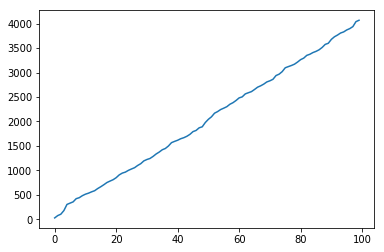

In [21]:
for i in range(100):
    history.append(train_play(Game(), learner)[1])
plt.plot(np.cumsum(history))

In [171]:
np.mean(history)

53.68547653779949

In [172]:
len(history)

1184

In [107]:
# import pickle
# with open('002_reinforcement_example_v2_learner.pickle', 'wb') as f:
#     pickle.dump({
#         'histories': learner.histories,
#         'value_model': [
#             {
#                 'config': model.get_config(),
#                 'weights': model.get_weights()
#             }
#             for model in learner.value_model
#         ]
#     }, f)

AttributeError: 'ScaledModel' object has no attribute 'get_config'

In [169]:
import pickle
with open('002_reinforcement_example_v5_learner_v3.pickle', 'wb') as f:
    pickle.dump(dict([(foo, learner.__dict__[foo]) for foo in learner.__dict__
                      if foo != "value_model" and foo != 'policy'] +
                     [("value_model", [{
                         "xscale": model.xscale,
                         "yscale": model.yscale,
                         "config": model.model.get_config(),
                         "weights": model.model.get_weights()
                     } for model in learner.value_model])]), f)

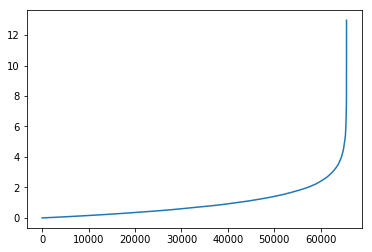

In [179]:
plt.plot(np.sort(learner.rewards))

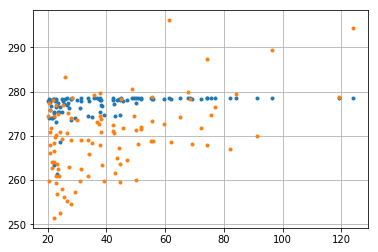

In [22]:
foo = np.zeros((100, 4))
for i in range(foo.shape[0]):
    foo[i, :4] = Game().get_state()
fooy0 = learner.value_model[0].predict(foo).reshape(-1)
fooy1 = learner.value_model[1].predict(foo).reshape(-1)
plt.plot(foo[:, 3], fooy0, '.')
plt.plot(foo[:, 3], fooy1, '.')
plt.grid()

In [56]:
np.min(learner.rewards)

4.490789154299005e-06

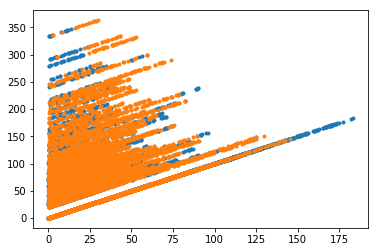

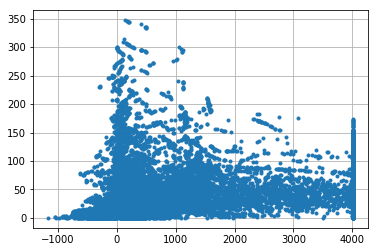

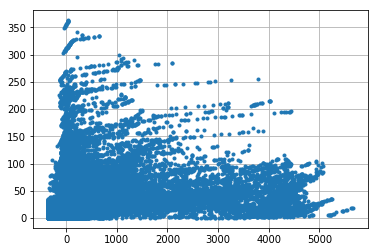

In [192]:
        cumrewards = np.empty(len(learner.states))
        for start, end in learner.ranges:
            cumrewards[start:end] = np.cumsum(learner.rewards[start:end])
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.plot(X[:, 3], Y, '.')
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.figure()
            plt.plot(learner.value_model[action].predict(X), Y, '.')
            #plt.title('Prediction vs response, RMS = {}'.format(learner.value_model[action].evaluate(X[inds], Y[inds])))
            plt.grid(True)

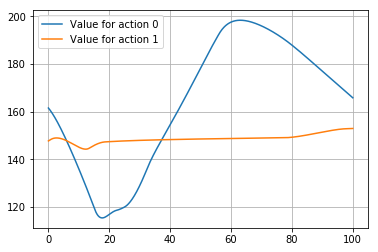

In [23]:
foo_heights = np.linspace(0, 100, 1000)
foo_states = np.empty((len(foo_heights), 4))
foo_states[:, 0] = foo_heights
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = 1
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_heights, foo_v, label="Value for action {}".format(action))
plt.grid(True)
plt.legend()

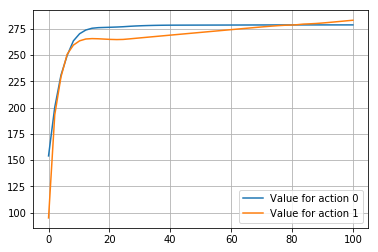

In [24]:
foo_dists = np.linspace(0, 100)
foo_states = np.empty((len(foo_dists), 4))
foo_states[:, 0] = 50
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = foo_dists
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_dists, foo_v, label="Value for action {}".format(action))
plt.legend()
plt.grid(True)

In [195]:
learner.policy.scale

1.1571137082807434

In [61]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += learner.cumrewards[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

AttributeError: 'TDLearner' object has no attribute 'cumrewards'

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


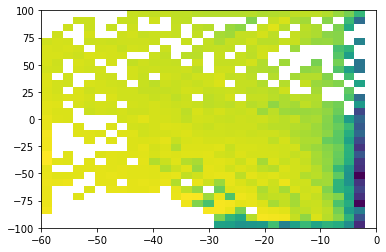

In [25]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
predictions = np.mean([model.predict(learner.states).reshape(-1) for model in learner.value_model], axis=0)
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += predictions[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

In [27]:
def mean_heatmap(x, y, z, xbins, ybins):
    xi = np.searchsorted(xbins, x)
    yi = np.searchsorted(ybins, y)
    totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
    counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
    for i in range(len(learner.states)):
        totals[xi[i], yi[i]] += z[i]
        counts[xi[i], yi[i]] += 1
    plt.imshow((totals / counts).T,
               origin = 'lower',
               aspect='auto',
               extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))
    plt.colorbar()
    plt.contour(np.linspace(xbins[0], xbins[-1], len(xbins) + 1),
                np.linspace(ybins[0], ybins[-1], len(ybins) + 1),
                (totals / counts).T,
                colors='k')


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


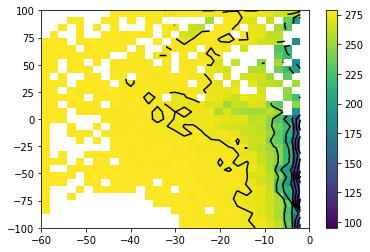

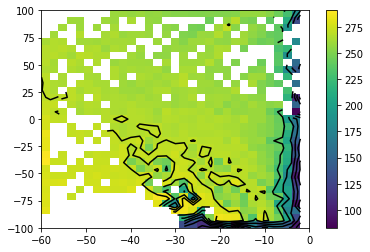

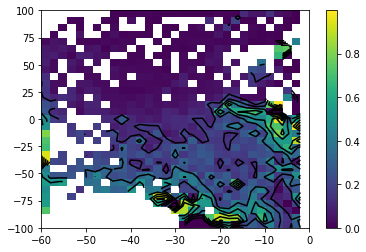

In [28]:
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
for action in range(learner.num_actions):
    predictions = learner.value_model[action].predict(learner.states).reshape(-1)
    plt.figure()
    mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

predictions = logodds_to_probs(learner.policy.predict(learner.states))[:, 1]
plt.figure()
mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

In [64]:
np.min(predictions), np.max(predictions)

(161.00038, 161.0004)

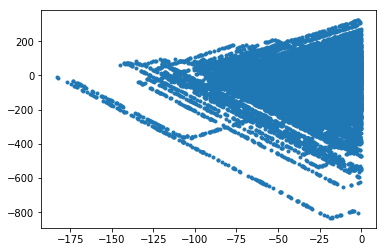

In [178]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
plt.plot(-learner.states[:, 3], dy, '.')

#### Test the ability of the neural network to learn...

In [ ]:
model = make_model(6, 1)

In [ ]:
data = np.random.rand(6000).reshape((1000, 6)) * 3

In [ ]:
for row in data:
    model.train_on_batch(row[np.newaxis, :], row[[-1]])

In [ ]:
foo = np.random.rand(600).reshape((100, 6)) * 3
fooy = model.predict(foo)
plt.plot(foo[:, -1], fooy.reshape(-1), '.')
plt.grid(True)